In [1]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import re
import sys
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from sr_model.models.models import AnalyticSR, STDP_SR
from datasets import inputs
import configs

device = 'cpu'

## Plot train loss for different gammas

In [4]:
gamma = 0.9
experiment_dir = f"../trained_models/02_nonlinearities/{gamma}/"
experiment_dir = f"/home/chingf/engram/Ching/02_nonlinearities/{gamma}/"
iterations = []
losses = []
exps = []
units = []

for nonlinearity in os.listdir(experiment_dir):
    nonlin_exp_dir = experiment_dir + f'{nonlinearity}/'
    
    files_to_collect = []
    files_losses = []
    
    for ic_iter in os.listdir(nonlin_exp_dir):
        if 'configs' in ic_iter: continue
        for file in os.listdir(nonlin_exp_dir + ic_iter):
            if 'tfevents' not in file: continue
            tfevents_file = nonlin_exp_dir + ic_iter + '/' + file
            event_acc = EventAccumulator(tfevents_file)
            event_acc.Reload()
            scalar_events = event_acc.Scalars('loss_train')
            loss = scalar_events[-1].value
            files_to_collect.append(tfevents_file)
            files_losses.append(loss)
            
    # Select Xth percentile
    sort_idxs = np.argsort(files_losses)
    sort_idxs = sort_idxs[:int(sort_idxs.size*0.9)]
    files_to_collect = [files_to_collect[idx] for idx in sort_idxs]
                
    for tfevents_file in files_to_collect:
        event_acc = EventAccumulator(tfevents_file)
        event_acc.Reload()
        scalar_events = event_acc.Scalars('loss_train')
        for i in range(len(scalar_events)):
            iterations.append(scalar_events[i].step)
            losses.append(scalar_events[i].value)
            exps.append(nonlinearity)
            units.append(ic_iter)
    
iterations = np.array(iterations)
losses = np.array(losses)
exps = np.array(exps)
units = np.array(units)

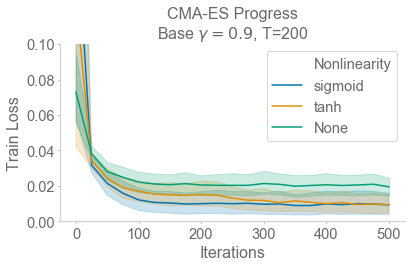

In [5]:
import seaborn as sns
import pandas as pd

df = pd.DataFrame(
    {'Iterations': iterations, 'Loss': losses, 'Nonlinearity': exps, 'Units':units}
    )
sns.lineplot(
    x='Iterations', y='Loss', hue='Nonlinearity', legend='full',
    data=df
    )
plt.xlabel('Iterations')
plt.ylabel('Train Loss')
plt.ylim(0, 0.1)
plt.title(f'CMA-ES Progress\nBase $\gamma={gamma}$, T=200')
plt.legend()
plt.tight_layout()
plt.savefig(f'2c_nonlin_gamma{gamma}.png', dpi=300)
plt.show()

# Plot final loss as a function of nonlinearity and gammas

In [13]:
root_dir = "../trained_models/02_nonlinearities/"
root_dir = "/home/chingf/engram/Ching/02_nonlinearities/"
gamma_dirs = ['0.4', '0.6', '0.8', '0.9', '0.95']
final_losses = []
gammas = []
nonlinearities = []
units = []

for gamma_dir in gamma_dirs:
    experiment_dir = root_dir + gamma_dir + '/'
    for nonlinearity in os.listdir(experiment_dir):
        nonlin_exp_dir = experiment_dir + f'{nonlinearity}/'
        
        iters_final_losses = []
        for ic_iter in os.listdir(nonlin_exp_dir):
            if 'configs' in ic_iter: continue
            for file in os.listdir(nonlin_exp_dir + ic_iter):
                if 'tfevents' not in file: continue
                tfevents_file = nonlin_exp_dir + ic_iter + '/' + file
                event_acc = EventAccumulator(tfevents_file)
                event_acc.Reload()
                try:
                    scalar_events = event_acc.Scalars('return_error')
                except:
                    continue
                val = scalar_events[-1].value
                iters_final_losses.append(val)
                
        # Collect Xth percentile
        iters_final_losses = np.sort(iters_final_losses).tolist()
        iters_final_losses = iters_final_losses[:int(len(iters_final_losses)*0.95)]
        final_losses.extend(iters_final_losses)
        gammas.extend([gamma_dir]*len(iters_final_losses))
        nonlinearities.extend([nonlinearity]*len(iters_final_losses))
        units.extend(range(len(iters_final_losses)))
final_losses = np.array(final_losses)
gammas = np.array(gammas)
nonlinearities = np.array(nonlinearities)
units = np.array(units)

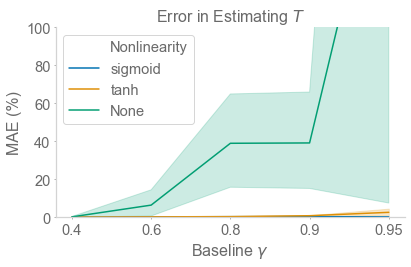

In [21]:
df = pd.DataFrame({
    'Gammas': gammas, 'Loss': final_losses*100,
    'Nonlinearity': nonlinearities, 'Units': units
    })
sns.lineplot(
    x='Gammas', y='Loss',
    hue='Nonlinearity', legend='full',
    data=df
    )
plt.xlabel('Baseline $\gamma$')
plt.ylabel('MAE (%)')
plt.title('Error in Estimating $T$')
plt.legend()
plt.ylim(0,100)
plt.tight_layout()
plt.savefig('2c_nonlin_gammas', dpi=300)
plt.show()

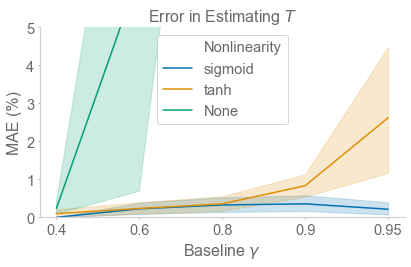

In [20]:
df = pd.DataFrame({
    'Gammas': gammas, 'Loss': final_losses*100,
    'Nonlinearity': nonlinearities, 'Units': units
    })
sns.lineplot(
    x='Gammas', y='Loss',
    hue='Nonlinearity', legend='full',
    data=df
    )
plt.xlabel('Baseline $\gamma$')
plt.ylabel('MAE (%)')
plt.title('Error in Estimating $T$')
plt.legend()
plt.ylim(0,5)
plt.tight_layout()
plt.savefig('2c_nonlin_gammas_zoomed', dpi=300)
plt.show()

# Plot sample transition matrices

In [4]:
root_dir = "../trained_models/02_nonlinearities/"
root_dir = "/home/chingf/engram/Ching/02_nonlinearities/"

gamma_dir = '0.9'
nonlinearities = []
M_matrices = []

# Test dataset
dset = inputs.Sim2DWalk(num_steps=3000, num_states=64)
dg_inputs = torch.from_numpy(dset.dg_inputs.T).float().to(device).unsqueeze(1)

# Go over each nonlinearity
experiment_dir = root_dir + gamma_dir + '/'
for nonlinearity in os.listdir(experiment_dir):
    nonlin_exp_dir = experiment_dir + f'{nonlinearity}/'

    iters_final_losses = []
    with open(nonlin_exp_dir + 'net_configs.p', 'rb') as f:
        net_configs = pickle.load(f)
    best_iter_dir = None; best_val = np.inf

    # Find best iteration
    for ic_iter in os.listdir(nonlin_exp_dir):
        if 'configs' in ic_iter: continue
        for file in os.listdir(nonlin_exp_dir + ic_iter):
            if 'tfevents' not in file: continue
            tfevents_file = nonlin_exp_dir + ic_iter + '/' + file
            event_acc = EventAccumulator(tfevents_file)
            event_acc.Reload()
            scalar_events = event_acc.Scalars('return_error')
            val = scalar_events[-1].value
            if val < best_val:
                best_val = val
                best_iter_dir = nonlin_exp_dir + ic_iter + '/'

    # Load that model and test
    net = STDP_SR(**net_configs)
    net.load_state_dict(torch.load(best_iter_dir + 'model.pt'))
    net.set_num_states(64)
    for step in range(dset.num_steps):
        curr_dg_input = dg_inputs[step].unsqueeze(0)
        reset = True if step == 0 else False
        with torch.no_grad():
            _ = net(curr_dg_input, reset=reset)
    nonlinearities.append(nonlinearity)
    M_matrices.append(net.get_M())

/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [5]:
nonlinearities

['sigmoid', 'tanh', 'None']

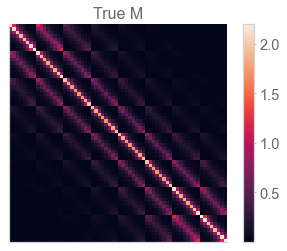

In [23]:
plt.figure()
T = dset.get_true_T()
M = np.linalg.pinv(np.eye(T.shape[0]) - float(gamma_dir)*T)
plt.imshow(M)
plt.title('True M')
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.savefig('2c_nonlin_trueT.png', dpi=300)
plt.show()

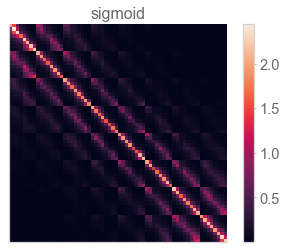

In [24]:
plt.figure()
plt.imshow(M_matrices[0].numpy())
plt.title(nonlinearities[0])
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.savefig('2c_nonlin_sigT.png', dpi=300)
plt.show()

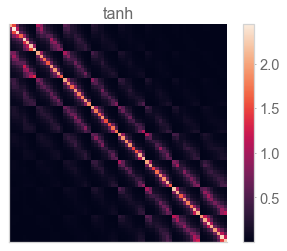

In [25]:
plt.figure()
plt.imshow(M_matrices[1].numpy())
plt.title(nonlinearities[1])
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.savefig('2c_nonlin_tanhT.png', dpi=300)
plt.show()

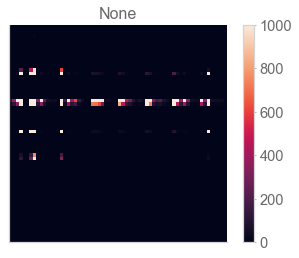

In [26]:
plt.figure()
plt.imshow(np.clip(M_matrices[2].numpy(), 0, 1E3))
plt.title(nonlinearities[2])
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.savefig('2c_nonlin_noneT.png', dpi=300)
plt.show()